In [1]:
#IMPORTING ALL THE NECESSARY LIBRARIES
import numpy as np
import pandas as pd


from sklearn.utils import resample
from sklearn.preprocessing import PowerTransformer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint


In [2]:
#READING THE DATASET (renamed the files)
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sample=pd.read_csv('sample.csv')

# Basic EDA

In [3]:
train.describe()

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn
count,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000
mean,41.130226,8.045954e+05,2.250226,0.515789,0.664361,0.231128
std,9.685747,5.157549e+05,1.458795,0.499788,0.472249,0.421586
min,21.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000
25%,34.000000,3.922642e+05,1.000000,0.000000,0.000000,0.000000
50%,40.000000,7.649386e+05,2.000000,1.000000,1.000000,0.000000
75%,47.000000,1.147124e+06,3.000000,1.000000,1.000000,0.000000
max,72.000000,2.436616e+06,5.000000,1.000000,1.000000,1.000000


In [4]:
#CHECK FOR NULL VALUES
train.isnull().sum()

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64

In [5]:
corr = train.corr()
corr

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn
Age,1.000000,0.002154,0.017353,0.032166,0.012089,0.204301
Balance,0.002154,1.000000,-0.019385,-0.005088,-0.025259,0.056380
Vintage,0.017353,-0.019385,1.000000,-0.027286,0.001856,0.020152
Transaction_Status,0.032166,-0.005088,-0.027286,1.000000,0.006526,-0.086917
Credit_Card,0.012089,-0.025259,0.001856,0.006526,1.000000,-0.000848
Is_Churn,0.204301,0.056380,0.020152,-0.086917,-0.000848,1.000000


<AxesSubplot:>

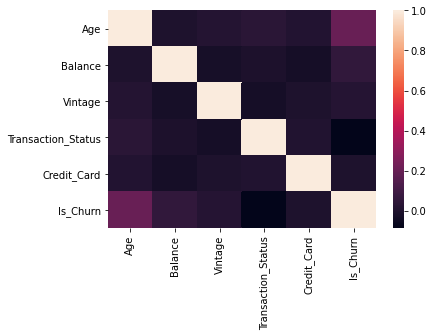

In [6]:
sns.heatmap(corr)

<AxesSubplot:xlabel='Income', ylabel='count'>

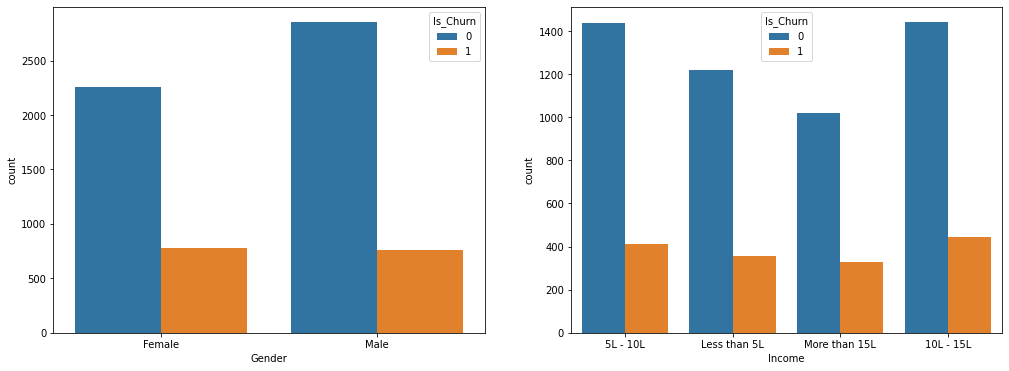

In [7]:
f, axes = plt.subplots(ncols=2,figsize=(17,6))
sns.countplot(x='Gender',hue='Is_Churn',ax=axes[0],data=train)
sns.countplot(x='Income',hue='Is_Churn',ax=axes[1],data=train)


<AxesSubplot:xlabel='Credit_Category', ylabel='count'>

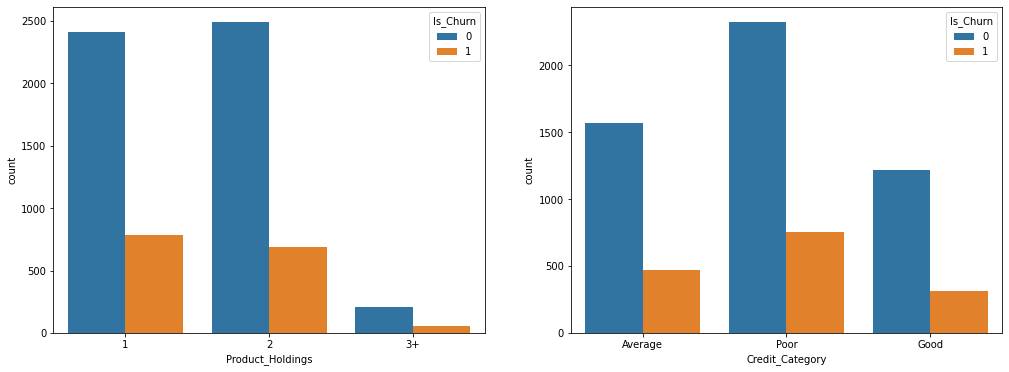

In [8]:
f, axes = plt.subplots(ncols=2,figsize=(17,6))
sns.countplot(x='Product_Holdings',hue='Is_Churn',ax=axes[0],data=train)
sns.countplot(x='Credit_Category',hue='Is_Churn',ax=axes[1],data=train)


In [9]:
#ADDING ALL CATEGORICAL COLUMNS IN AN ARRAY
categorical_columns=[]
for column in train.columns:
    if(train[column].dtype=='object' and column!='ID'):
        categorical_columns.append(column)
        
#CHECKING FOR CLASSES IMBALANCE WITHIN THE FEATURES
for column in categorical_columns:
    print(train[column].value_counts())
    print("---------------------------")

Male      3612
Female    3038
Name: Gender, dtype: int64
---------------------------
10L - 15L        1885
5L - 10L         1847
Less than 5L     1573
More than 15L    1345
Name: Income, dtype: int64
---------------------------
1     3200
2     3182
3+     268
Name: Product_Holdings, dtype: int64
---------------------------
Poor       3076
Average    2043
Good       1531
Name: Credit_Category, dtype: int64
---------------------------


# Data Sampling & Finalizing for Prediction

In [10]:
#ONE HOT ENCODING FOR CATEGORICAL VARIABLES
dummy_col_train = pd.get_dummies(train[categorical_columns])
dummy_col_test = pd.get_dummies(test[categorical_columns])

In [11]:
#CONCATENATING THE DUMMY COLUMNS
train=pd.concat([train,dummy_col_train],axis=1)
test=pd.concat([test,dummy_col_test],axis=1)

In [12]:
#DROP THE CATEGORICAL VARIABLES and ID column
train=train.drop(['Gender', 'Income', 'Product_Holdings', 'Credit_Category','ID'],axis=1)
test=test.drop(['Gender', 'Income', 'Product_Holdings', 'Credit_Category','ID'],axis=1)

In [13]:
train.head()

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn,Gender_Female,Gender_Male,Income_10L - 15L,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Product_Holdings_1,Product_Holdings_2,Product_Holdings_3+,Credit_Category_Average,Credit_Category_Good,Credit_Category_Poor
0,36,563266.44,4,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0
1,53,875572.11,2,1,1,0,1,0,0,0,1,0,1,0,0,0,0,1
2,35,701607.06,2,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1
3,43,1393922.16,0,1,1,1,1,0,0,0,0,1,0,1,0,0,0,1
4,39,893146.23,1,1,1,1,1,0,0,0,0,1,1,0,0,0,1,0


In [14]:
test.head()

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Gender_Female,Gender_Male,Income_10L - 15L,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Product_Holdings_1,Product_Holdings_2,Product_Holdings_3+,Credit_Category_Average,Credit_Category_Good,Credit_Category_Poor
0,50,1008636.39,2,1,1,1,0,0,0,0,1,0,1,0,1,0,0
1,36,341460.72,2,0,1,0,1,0,1,0,0,0,1,0,1,0,0
2,25,439460.10,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0
3,41,28581.93,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1
4,48,1104540.03,2,1,0,0,1,0,0,0,1,0,0,1,0,1,0


In [15]:
#CHECK CLASS IMBALANCE FOR TARGET VARIABLE
train['Is_Churn'].value_counts()

0    5113
1    1537
Name: Is_Churn, dtype: int64

In [16]:
train_0=train[train.Is_Churn==0]
train_1=train[train.Is_Churn==1]

In [17]:
#RESAMPLING BOTH CLASSES TO 2500 size
train_0=resample(train_0,replace=True,n_samples=2500,random_state=27)
train_1=resample(train_1,replace=True,n_samples=2500,random_state=27)

In [18]:
#Concat both the classes to get balanced dataset
upsampled_x = pd.concat([train_0,train_1])
upsampled_x.head()

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn,Gender_Female,Gender_Male,Income_10L - 15L,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Product_Holdings_1,Product_Holdings_2,Product_Holdings_3+,Credit_Category_Average,Credit_Category_Good,Credit_Category_Poor
4881,29,316866.24,4,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0
5082,52,81972.00,4,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1
6298,27,618869.70,3,1,1,0,0,1,1,0,0,0,0,1,0,0,1,0
5488,52,987165.63,3,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0
3786,30,1784986.20,4,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1


In [19]:
#Reset the index and drop the index column
upsampled_x.reset_index(inplace=True)
upsampled_x=upsampled_x.drop(['index'],axis=1)
upsampled_x.head()

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn,Gender_Female,Gender_Male,Income_10L - 15L,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Product_Holdings_1,Product_Holdings_2,Product_Holdings_3+,Credit_Category_Average,Credit_Category_Good,Credit_Category_Poor
0,29,316866.24,4,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0
1,52,81972.00,4,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1
2,27,618869.70,3,1,1,0,0,1,1,0,0,0,0,1,0,0,1,0
3,52,987165.63,3,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0
4,30,1784986.20,4,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1


In [20]:
#Separating the target and train features
y_upsampled=upsampled_x['Is_Churn']
upsampled_x=upsampled_x.drop(['Is_Churn'],axis=1)

In [21]:
#Scaling the train and test features
pt = PowerTransformer()
x_train=pt.fit_transform(upsampled_x)
x_test=pt.fit_transform(test)

# Modelling

In [22]:
#Importing the Random Forest Model
rf=RandomForestClassifier()

In [23]:
#Fitting the model
rf.fit(x_train,y_upsampled)

RandomForestClassifier()

In [24]:
#Getting the Predictions
y_rf=rf.predict(x_test)
y_rf

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [25]:
sample['Is_Churn']=y_rf
sample.head()

,ID,Is_Churn
0,55480787,0
1,9aededf2,1
2,a5034a09,0
3,b3256702,0
4,dc28adb5,0


In [26]:
#Storing the results in csv file
sample.to_csv('submission.csv',index=False)